<a href="https://colab.research.google.com/github/Ishat2038/Keyframe-Extraction-Comparison-Using-ResNet50-with-Skin-Segmentation-and-Bilateral-Filtering/blob/main/Keyframe_Extraction_Resnet50_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Connect google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import libraries**

In [23]:
# Computer Vision and Image Processing
import cv2
from skimage import io

# Numerical Computation
import numpy as np
import math

# File and Directory Management
import os
import shutil

# Deep Learning and Feature Extraction
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Utility
from tqdm import tqdm

## **Step 1: Extract frames from video**

Folder path

In [3]:
video_path = "/content/drive/MyDrive/HGR_dataset/allgest/allgesture.mp4"
output_folder = "/content/drive/MyDrive/HGR_dataset/allgest/allframes"
os.makedirs(output_folder, exist_ok=True)

In [4]:
# Confirm the file exists
if not os.path.exists(video_path):
    print("Video file does not exist. Check the path.")
    raise SystemExit

In [5]:
# Open video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: OpenCV could not open the video.")
    raise SystemExit

Skin region segmentation function

In [6]:
# Skin segmentation function to identify skin regions
def skin_segmentation(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_threshold = np.array([0, 48, 80])
    upper_threshold = np.array([20, 255, 255])
    skin_mask = cv2.inRange(hsv, lower_threshold, upper_threshold)

    contours, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cv2.drawContours(skin_mask, [cnt], -1, 255, 3)
        kernel = np.ones((3, 3), np.uint8)
        skin_mask = cv2.dilate(skin_mask, kernel, iterations=1)
    return skin_mask

**Extracting frames (specific size & skin region)**

In [ ]:
# Frame processing loop
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    bilateral = cv2.bilateralFilter(frame, 9, 75, 75)
    skin_mask = skin_segmentation(bilateral)

    desired_width = 400
    desired_height = 400

    contours, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    chosen_contour = None
    max_area = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            chosen_contour = cnt

    if chosen_contour is not None:
        x, y, w, h = cv2.boundingRect(chosen_contour)
        hand_region = frame[y:y+h, x:x+w]
        resized_hand = cv2.resize(hand_region, (desired_width, desired_height))

        # Save the extracted frame
        frame_name = os.path.join(output_folder, f"Frame_{frame_count+1}.png")
        #print(f"Frame {frame_count+1} saved to {frame_name}")
        cv2.imwrite(frame_name, resized_hand)
    frame_count += 1
cap.release()
print(f"Frame extraction complete and {frame_count} saved to {output_folder}")

Frame extraction complete and 438 saved to /content/drive/MyDrive/HGR_dataset/allgest/allframes


Visualize raw extracted frames

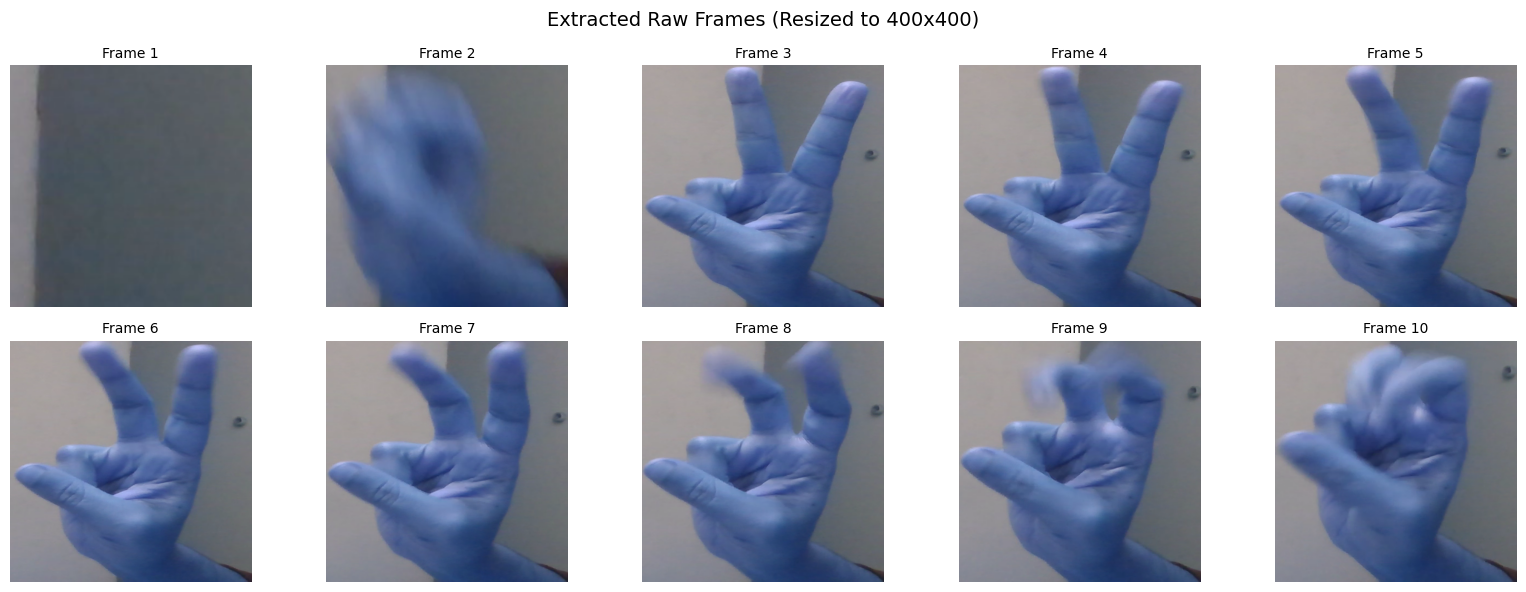

In [7]:
# List all extracted frames
extracted_frames = sorted([
    os.path.join(output_folder, f)
    for f in os.listdir(output_folder) if f.endswith('.png')
])

# Display the first 10 extracted frames
num_to_display = min(10, len(extracted_frames))
plt.figure(figsize=(16, 6))

for i in range(num_to_display):
    img = io.imread(extracted_frames[i])
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title(f"Frame {i+1}", fontsize=10)
    plt.axis('off')

plt.suptitle("Extracted Raw Frames (Resized to 400x400)", fontsize=14)
plt.tight_layout()
plt.show()

## **Step 2: Preprocessing**

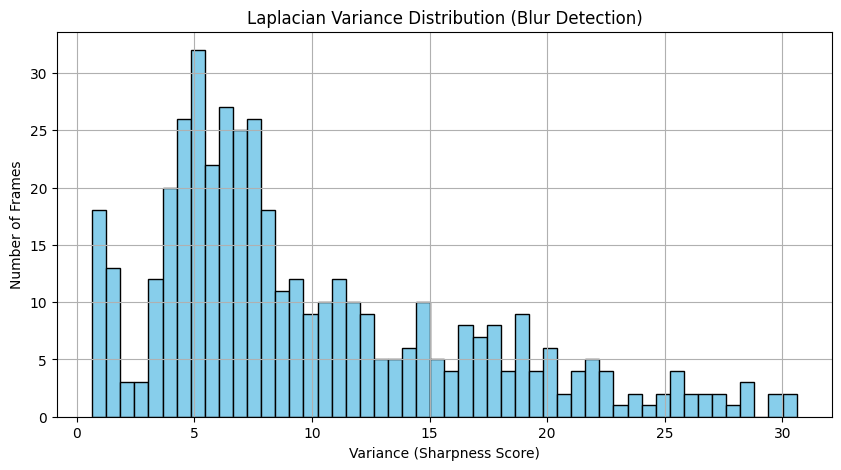

✅ Suggested Threshold (25th percentile): 5.19

✅ Done! Clean frames kept: 328, blurry frames removed: 110
🗂️ Clean frames saved to: /content/drive/MyDrive/HGR_dataset/allgest/clean_frames


In [ ]:
#Folders destination
input_folder = "/content/drive/MyDrive/HGR_dataset/allgest/allframes"
clean_folder = "/content/drive/MyDrive/HGR_dataset/allgest/clean_frames"
os.makedirs(clean_folder, exist_ok=True)

laplacian_scores = []

#STEP 1: Calculate Laplacian Variance for Each Image
for fname in os.listdir(input_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(input_folder, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        var = cv2.Laplacian(gray, cv2.CV_64F).var()
        laplacian_scores.append((fname, var))

#STEP 2: Analyze Scores
all_scores = np.array([v for (_, v) in laplacian_scores])

plt.figure(figsize=(10, 5))
plt.hist(all_scores, bins=50, color='skyblue', edgecolor='black')
plt.title("Laplacian Variance Distribution (Blur Detection)")
plt.xlabel("Variance (Sharpness Score)")
plt.ylabel("Number of Frames")
plt.grid(True)
plt.show()

#STEP 3: Determine Threshold Automatically
suggested_threshold = np.percentile(all_scores, 25)
print(f"✅ Suggested Threshold (25th percentile): {suggested_threshold:.2f}")

# --- STEP 4: Filter Frames Based on Threshold ---
kept, removed = 0, 0
for fname, score in laplacian_scores:
    src_path = os.path.join(input_folder, fname)
    dst_path = os.path.join(clean_folder, fname)

    if score >= suggested_threshold:
        shutil.copy(src_path, dst_path)
        kept += 1
    else:
        removed += 1

print(f"\n✅ Done! Clean frames kept: {kept}, blurry frames removed: {removed}")
print(f"🗂️ Clean frames saved to: {clean_folder}")

Visualize preprocessed frames

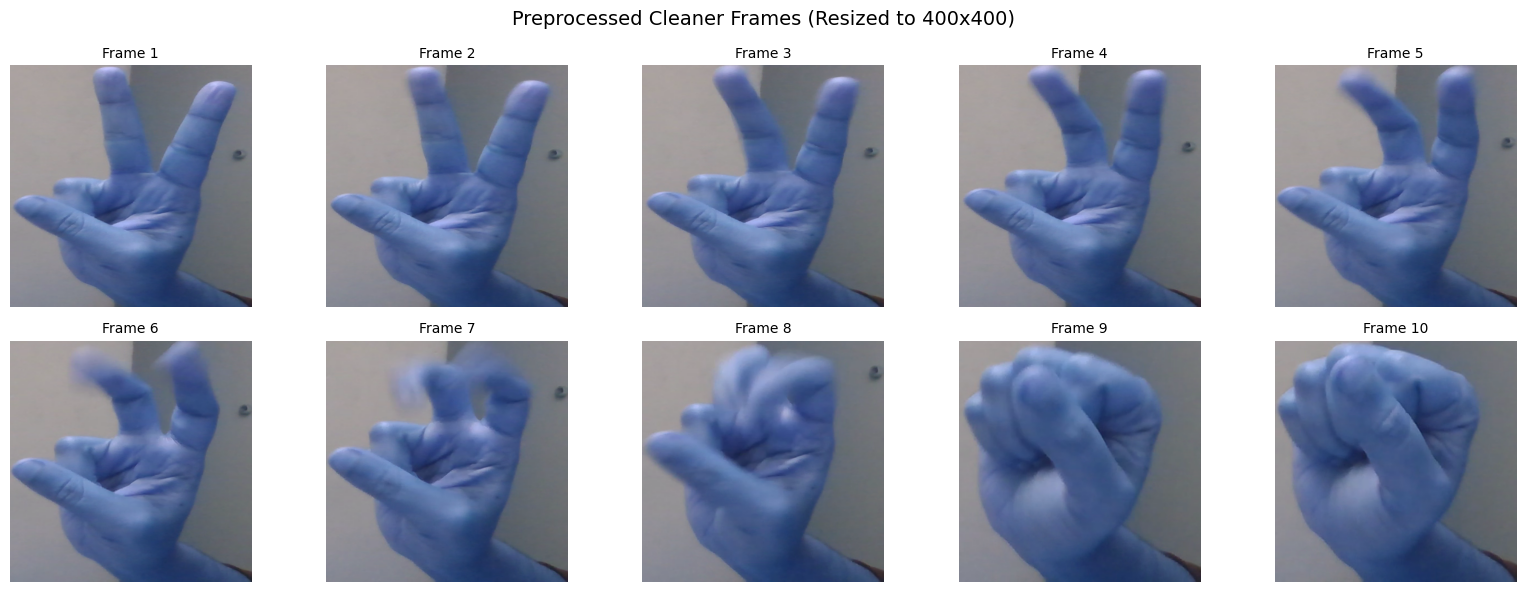

In [13]:
import matplotlib.pyplot as plt
from skimage import io
clean_folder = "/content/drive/MyDrive/HGR_dataset/allgest/clean_frames"

# List all extracted frames
extracted_frames = sorted([
    os.path.join(clean_folder, f)
    for f in os.listdir(clean_folder) if f.endswith('.png')
])

# Display the first 10 extracted frames
num_to_display = min(10, len(extracted_frames))
plt.figure(figsize=(16, 6))

for i in range(num_to_display):
    img = io.imread(extracted_frames[i])
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title(f"Frame {i+1}", fontsize=10)
    plt.axis('off')

plt.suptitle("Preprocessed Cleaner Frames (Resized to 400x400)", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
!pip install opencv-python scikit-image

## **Step 3: Extracting keyframes using pre-trained Resnet-50 model**
**Comparing difference of using pooling methods between**

1.   Global Average Pooling (GAP)
2.   Global Max Pooling (GMP)


**1. Using Global Average Pooling**

In [17]:
# Load ResNet50 model for feature extraction
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def get_deep_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features[0]

def calculate_deep_differences(folder_path):
    frame_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')])
    diffs = []
    for i in tqdm(range(len(frame_files) - 1), desc="Calculating frame differences"):
        f1 = get_deep_features(frame_files[i])
        f2 = get_deep_features(frame_files[i + 1])
        similarity = cosine_similarity([f1], [f2])[0][0]
        diff = 1 - similarity  # Higher = more different
        diffs.append((frame_files[i], diff))
    return diffs

def select_high_motion_frames(frame_diffs, num_frames_to_select=50, min_diff_threshold=0.05, suppression_window=5):
    filtered = [(f, d) for f, d in frame_diffs if d > min_diff_threshold]
    filtered.sort(key=lambda x: x[1], reverse=True)

    selected = []
    used_indices = set()
    for fname, diff in filtered:
        orig_idx = next(i for i, (f, _) in enumerate(frame_diffs) if f == fname)
        if all(abs(orig_idx - si) > suppression_window for si in used_indices):
            selected.append((fname, diff))
            used_indices.add(orig_idx)
        if len(selected) >= num_frames_to_select:
            break
    return selected

input_frames_dir = "/content/drive/MyDrive/HGR_dataset/allgest/clean_frames"
keyframes_dir = "/content/drive/MyDrive/HGR_dataset/allgest/keyframes"
unselected_dir = "/content/drive/MyDrive/HGR_dataset/allgest/unselected"
os.makedirs(keyframes_dir, exist_ok=True)
os.makedirs(unselected_dir, exist_ok=True)

# === Process ===
frame_diffs = calculate_deep_differences(input_frames_dir)
high_motion_frames = select_high_motion_frames(
    frame_diffs,
    num_frames_to_select=50,
    min_diff_threshold=0.05,
    suppression_window=5
)

# Save selected keyframes
selected_frame_paths = set([f for f, _ in high_motion_frames])
all_frames = sorted([os.path.join(input_frames_dir, f) for f in os.listdir(input_frames_dir) if f.endswith('.png')])

selected_count, unselected_count = 0, 0

for frame in all_frames:
    dest_folder = keyframes_dir if frame in selected_frame_paths else unselected_dir
    shutil.copy(frame, os.path.join(dest_folder, os.path.basename(frame)))
    if frame in selected_frame_paths:
        selected_count += 1
    else:
        unselected_count += 1

print(f"\n Saved {selected_count} keyframes to: {keyframes_dir}")
print(f" Saved {unselected_count} unselected frames to: {unselected_dir}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Calculating frame differences: 100%|██████████| 327/327 [01:14<00:00,  4.37it/s]



 Saved 30 keyframes to: /content/drive/MyDrive/HGR_dataset/allgest/keyframes
 Saved 298 unselected frames to: /content/drive/MyDrive/HGR_dataset/allgest/unselected


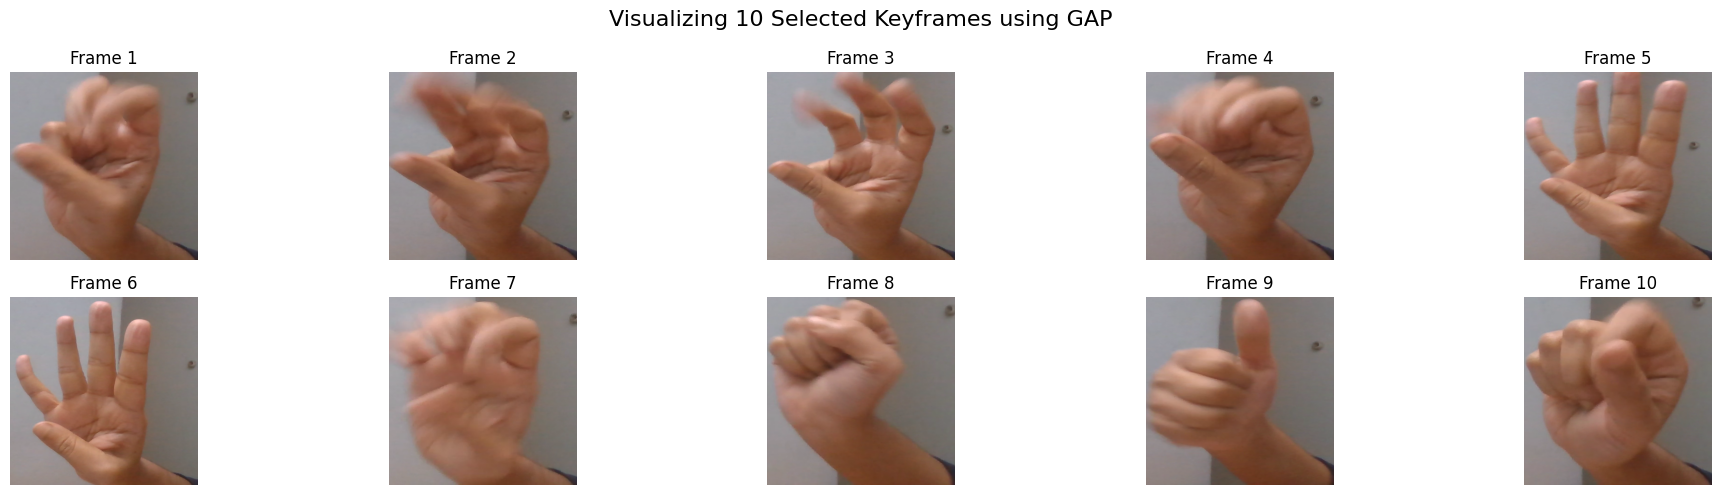

In [18]:
import matplotlib.pyplot as plt
import cv2
import os

# Path to keyframes folder
keyframes_dir = "/content/drive/MyDrive/HGR_dataset/allgest/keyframes"

# Get list of frame paths
frame_files = sorted([
    os.path.join(keyframes_dir, f)
    for f in os.listdir(keyframes_dir) if f.endswith('.png')
])

# Select first 10 frames
num_to_display = min(10, len(frame_files))

# Plot the frames
plt.figure(figsize=(20, 5))
for i in range(num_to_display):
    img = cv2.imread(frame_files[i])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"Frame {i+1}")
    plt.axis('off')

plt.suptitle("Visualizing 10 Selected Keyframes using GAP", fontsize=16)
plt.tight_layout()
plt.show()

**2. Using Global Maxpooling**

In [ ]:
# Load ResNet50 model for feature extraction
model = ResNet50(weights='imagenet', include_top=False, pooling='max')

def get_deep_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features[0]

def calculate_deep_differences(folder_path):
    frame_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')])
    diffs = []
    for i in tqdm(range(len(frame_files) - 1), desc="Calculating frame differences"):
        f1 = get_deep_features(frame_files[i])
        f2 = get_deep_features(frame_files[i + 1])
        similarity = cosine_similarity([f1], [f2])[0][0]
        diff = 1 - similarity  # Higher = more different
        diffs.append((frame_files[i], diff))
    return diffs

def select_high_motion_frames(frame_diffs, num_frames_to_select=50, min_diff_threshold=0.05, suppression_window=5):
    filtered = [(f, d) for f, d in frame_diffs if d > min_diff_threshold]
    filtered.sort(key=lambda x: x[1], reverse=True)

    selected = []
    used_indices = set()
    for fname, diff in filtered:
        orig_idx = next(i for i, (f, _) in enumerate(frame_diffs) if f == fname)
        if all(abs(orig_idx - si) > suppression_window for si in used_indices):
            selected.append((fname, diff))
            used_indices.add(orig_idx)
        if len(selected) >= num_frames_to_select:
            break
    return selected
#folder paths
input_frames_dir = "/content/drive/MyDrive/HGR_dataset/allgest/clean_frames"
keyframes_dir = "/content/drive/MyDrive/HGR_dataset/allgest/keyframes_new"
unselected_dir = "/content/drive/MyDrive/HGR_dataset/allgest/unselected_new"
os.makedirs(keyframes_dir, exist_ok=True)
os.makedirs(unselected_dir, exist_ok=True)

#Process
frame_diffs = calculate_deep_differences(input_frames_dir)
high_motion_frames = select_high_motion_frames(
    frame_diffs,
    num_frames_to_select=50,
    min_diff_threshold=0.05,
    suppression_window=5
)

# Save selected keyframes
selected_frame_paths = set([f for f, _ in high_motion_frames])
all_frames = sorted([os.path.join(input_frames_dir, f) for f in os.listdir(input_frames_dir) if f.endswith('.png')])

selected_count, unselected_count = 0, 0

for frame in all_frames:
    dest_folder = keyframes_dir if frame in selected_frame_paths else unselected_dir
    shutil.copy(frame, os.path.join(dest_folder, os.path.basename(frame)))
    if frame in selected_frame_paths:
        selected_count += 1
    else:
        unselected_count += 1

print(f"\n Saved {selected_count} keyframes to: {keyframes_dir}")
print(f" Saved {unselected_count} unselected frames to: {unselected_dir}")

Calculating frame differences: 100%|██████████| 327/327 [01:08<00:00,  4.80it/s]



 Saved 33 keyframes to: /content/drive/MyDrive/HGR_dataset/allgest/keyframes_new
 Saved 295 unselected frames to: /content/drive/MyDrive/HGR_dataset/allgest/unselected_new


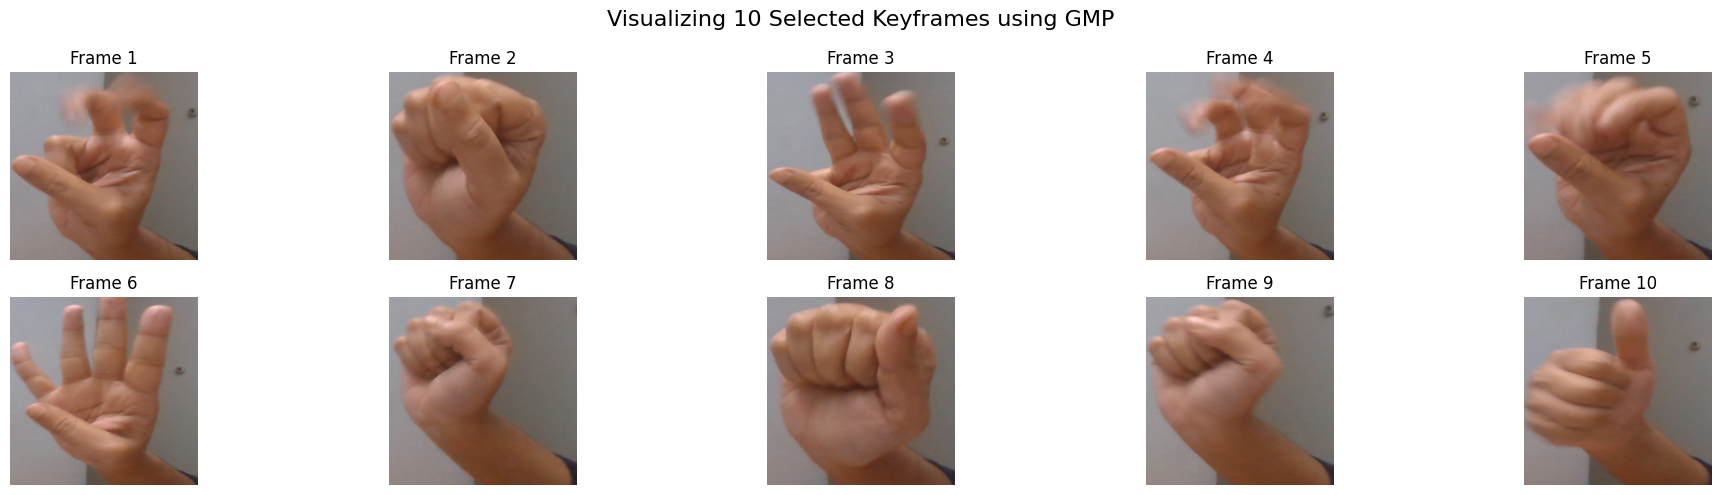

In [19]:
# Path to keyframes folder
keyframes_dir = "/content/drive/MyDrive/HGR_dataset/allgest/keyframes_new"

# Get list of frame paths
frame_files = sorted([
    os.path.join(keyframes_dir, f)
    for f in os.listdir(keyframes_dir) if f.endswith('.png')
])

# Select first 10 frames
num_to_display = min(10, len(frame_files))

# Plot the frames
plt.figure(figsize=(20, 5))
for i in range(num_to_display):
    img = cv2.imread(frame_files[i])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"Frame {i+1}")
    plt.axis('off')

plt.suptitle("Visualizing 10 Selected Keyframes using GMP", fontsize=16)
plt.tight_layout()
plt.show()

## **Step 4: Comparing the performances between GAP and GMP**

In [20]:
# Load ResNet50 without top layers
def load_model(pooling='avg'):
    return ResNet50(weights='imagenet', include_top=False, pooling=pooling)

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features[0]

def compute_average_diversity(feature_list):
    sims = []
    for i in range(len(feature_list)):
        for j in range(i+1, len(feature_list)):
            sim = cosine_similarity([feature_list[i]], [feature_list[j]])[0][0]
            sims.append(1 - sim)
    return np.mean(sims)

# === Directories ===
gap_dir = "/content/drive/MyDrive/HGR_dataset/allgest/keyframes"
gmp_dir = "/content/drive/MyDrive/HGR_dataset/allgest/keyframes_new"

gap_files = sorted([os.path.join(gap_dir, f) for f in os.listdir(gap_dir) if f.endswith('.png')])
gmp_files = sorted([os.path.join(gmp_dir, f) for f in os.listdir(gmp_dir) if f.endswith('.png')])

# Load models
gap_model = load_model(pooling='avg')
gmp_model = load_model(pooling='max')

# Extract features
gap_features = [extract_features(f, gap_model) for f in tqdm(gap_files, desc="GAP Features")]
gmp_features = [extract_features(f, gmp_model) for f in tqdm(gmp_files, desc="GMP Features")]

# Intra-set diversity
gap_diversity = compute_average_diversity(gap_features)
gmp_diversity = compute_average_diversity(gmp_features)

# Inter-set similarity (average cosine similarity between corresponding frames)
inter_set_similarity = np.mean([
    cosine_similarity([gap_feat], [gmp_feat])[0][0]
    for gap_feat, gmp_feat in zip(gap_features, gmp_features)
])

# === Report ===
print(f"\n Intra-set Diversity (Higher = Better):")
print(f" - GAP Diversity Score: {gap_diversity:.4f}")
print(f" - GMP Diversity Score: {gmp_diversity:.4f}")

print(f"\n Inter-set Similarity (Lower = More Different Selections):")
print(f" - GAP vs GMP Average Cosine Similarity: {inter_set_similarity:.4f}")

GMP Features: 100%|██████████| 33/33 [00:13<00:00,  2.41it/s]



 Intra-set Diversity (Higher = Better):
 - GAP Diversity Score: 0.1781
 - GMP Diversity Score: 0.2087

 Inter-set Similarity (Lower = More Different Selections):
 - GAP vs GMP Average Cosine Similarity: 0.7451


In [22]:
# === Performance Verdict ===
print("Final Verdict:")
if gap_diversity > gmp_diversity:
    print(" GAP (Global Average Pooling) selected more diverse keyframes and may better capture scene variation.")
elif gmp_diversity > gap_diversity:
    print(" GMP (Global Max Pooling) selected more diverse keyframes and may better capture scene variation.")
else:
    print(" Both methods resulted in equal diversity. Consider reviewing visual quality or motion relevance.")


Final Verdict:
 GMP (Global Max Pooling) selected more diverse keyframes and may better capture scene variation.
